# Let's see how our code compares to Keras in terms of speed
First we do a Keras prediction

In [56]:
#System imports
from __future__ import print_function

#External imports 
from keras import layers, models
from keras import backend as K
from matplotlib import pyplot as plt

#Local imports 
from naive_prediction.data_utils import read_keras_model_from_file, get_layer_type
from pyopencl_prediction.pyopencl_forward_pass import predict, build_kernels, Predictor
from data import generate_straight_tracks
from drawing import draw_2d_event, draw_2d_input_and_pred

#For consistent printing
import numpy as np
import pyopencl as cl
from pyopencl import array
np.set_printoptions(suppress=True)

#to test performance
import time

%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
#load the model
model = read_keras_model_from_file('/Users/Thomas/Desktop/opencl-cnn/model1.h5')

#test input generator
def batch_generator_convae(num_event, det_shape, num_tracks, binary=True):
    """
    Generator function for batches of toy data for training.
    This function generates a fixed number of tracks in a batch.
    """
    while True:
        events = sum(generate_straight_tracks(num_event, det_shape)
                     for i in range(num_tracks))
        if binary:
            events[events > 1] = 1
        # Input and target are the same here
        yield events, events

In [90]:
det_shape = (64, 64)
num_tracks = 16
#print("first one beginning")
keras_prediction_num_events_vs_time = ([], []) #x, y
for num_test in range(0, 101, 5):
    #print("iteration number", num_test) 
    test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
    start = time.time()
    test_pred = model.predict(test_events)
    end = time.time()
    keras_prediction_num_events_vs_time[0].append(num_test)
    keras_prediction_num_events_vs_time[1].append(end-start)
#print("first one done")
num_test = 10
keras_prediction_num_tracks_vs_time = ([], [])
inc = 8
for i in range(1, 6):
    num_tracks = 8**i
    test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
    start = time.time()
    test_pred = model.predict(test_events)
    end = time.time()
    keras_prediction_num_tracks_vs_time[0].append(num_tracks)
    keras_prediction_num_tracks_vs_time[1].append(end-start)
    inc = inc*8 - inc

<IPython.core.display.Javascript object>


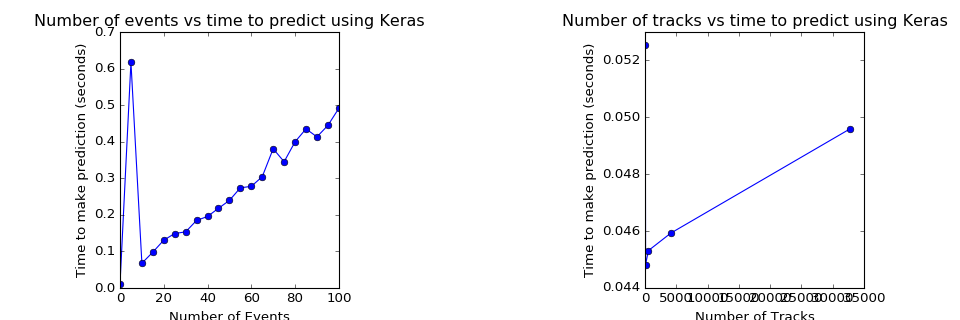

In [91]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(keras_prediction_num_events_vs_time[0], keras_prediction_num_events_vs_time[1], '-o')
plt.xlabel('Number of Events')
plt.ylabel('Time to make prediction (seconds)')
plt.title('Number of events vs time to predict using Keras')
plt.subplot(133)
plt.plot(keras_prediction_num_tracks_vs_time[0], keras_prediction_num_tracks_vs_time[1], '-o')
plt.xlabel('Number of Tracks')
plt.ylabel('Time to make prediction (seconds)')
plt.title('Number of tracks vs time to predict using Keras')
plt.show()

Looks like this is linear with number of tracks, I'll stick with number of events in that case. Looks like essentially linear growth for Keras. Now let's try our code! First we'll just use the standard python code.

In [101]:
our_predictor = Predictor(model)
pyopencl_prediction_num_events_vs_time = ([], []) #x, y
for num_test in range(0, 26, 5):
    if num_test == 0:
        pyopencl_prediction_num_events_vs_time[0].append(0)
        pyopencl_prediction_num_events_vs_time[1].append(0)
        continue
    print("iteration number", num_test) 
    test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
    start = time.time()
    #print(test_events.shape)
    test_pred = our_predictor.predict(test_events)
    end = time.time()
    print(test_pred)
    print(end-start)
    pyopencl_prediction_num_events_vs_time[0].append(num_test)
    pyopencl_prediction_num_events_vs_time[1].append(end-start)

iteration number 5
Conv time for preprocess 0.00139188766479
Conv time of cl array stuff 0.00172781944275
Conv time of conv operation 0.00795912742615
Conv time for preprocess 0.000921964645386
Conv time of cl array stuff 0.000885009765625
Conv time of conv operation 0.00566911697388
Pooling time to preprocess 0.000241041183472
Pooling time to create zeros array 0.000226020812988
Pooling time for actual operation 0.00542187690735
Conv time for preprocess 0.000627994537354
Conv time of cl array stuff 0.000451803207397
Conv time of conv operation 0.00508522987366
Pooling time to preprocess 0.000193119049072
Pooling time to create zeros array 0.000298023223877
Pooling time for actual operation 0.00550603866577
Conv time for preprocess 0.000455856323242
Conv time of cl array stuff 0.000652074813843
Conv time of conv operation 0.0054759979248
Pooling time to preprocess 0.000277996063232
Pooling time to create zeros array 0.000344038009644
Pooling time for actual operation 0.0042929649353
Co

<IPython.core.display.Javascript object>


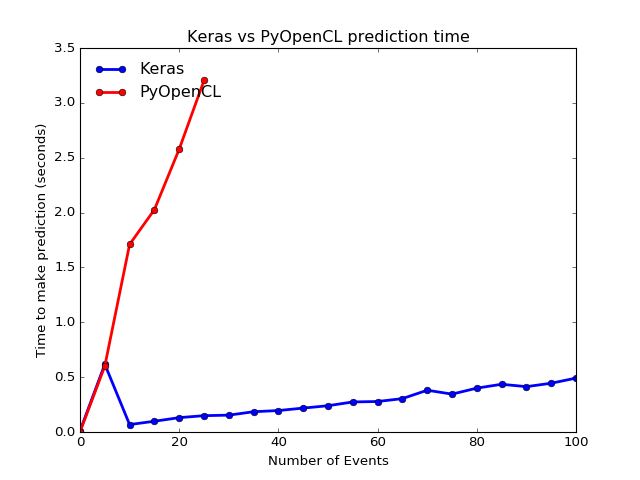

In [102]:
plt.figure()
plt.plot(keras_prediction_num_events_vs_time[0], keras_prediction_num_events_vs_time[1], '-o', color="blue", linewidth=2.5, linestyle="-", label="Keras")
plt.plot(pyopencl_prediction_num_events_vs_time[0], pyopencl_prediction_num_events_vs_time[1], '-o', color="red", linewidth=2.5, linestyle="-", label="PyOpenCL")
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Number of Events')
plt.ylabel('Time to make prediction (seconds)')
plt.title('Keras vs PyOpenCL prediction time')
plt.show()

Ok so our result is quite bad. Let's break down our prediction to see what causes our prediction to be so much slower than Keras'. I think Keras may be using our GPU,let's see what happens if I have OpenCL use the GPU as well.

In [7]:
from pyopencl_prediction.pyopencl_forward_pass import reshape, convolution_2d, maxpooling_2d, upsampling_2d
test_events, test_target = batch_generator_convae(3, det_shape, num_tracks).next()
total_times = []
conv_times = []
pool_times = []
reshape_times = []
upsampling_times = []
for event in test_events:
    totst = time.time()
    #print(event.shape)
    event = np.reshape(event, event.shape + (1,))
    prediction = event
    for layer in model.layers:

        #get layer information via keras
        layer_type = get_layer_type(layer)
        layer_config = layer.get_config()

        #perform appropriate operation
        if layer_type == 'convolution2d':
            start = time.time()
            prediction = convolution_2d(prediction, layer.get_weights(), 1, prg, queue, activation=layer_config['activation'], padding='same')
            end = time.time()
            conv_times.append(end-start)
        if layer_type == 'maxpooling2d':
            start = time.time()
            prediction = maxpooling_2d(prediction, layer_config['pool_size'][0], layer_config['strides'][0], prg, queue)
            end = time.time()
            pool_times.append(end-start)
        #not parallelized
        if layer_type == 'reshape':
            start = time.time()
            prediction = reshape(prediction, layer_config['target_shape'])
            end = time.time()
            reshape_times.append(end-start)
        if layer_type == 'upsampling2d':
            start = time.time()
            prediction = upsampling_2d(prediction, layer_config['size'][0])
            end = time.time()
            upsampling_times.append(end-start)
    #all_predictions.append(prediction)
    totend = time.time()
    total_times.append(totend-totst)

In [8]:
def avg(some_list):
    return sum(some_list) / float(len(some_list))

In [9]:
print(avg(total_times))
print(avg(conv_times))
print(avg(pool_times))
print(avg(reshape_times))
print(avg(upsampling_times))

0.28769270579
0.0196893398578
0.00989654329088
1.00135803223e-05
7.36713409424e-05


In [10]:
#rather unsurprisingly numpy has done a much better job than I have.
#let's dig deeper!!!

In [11]:
def zero_pad_matrix(input_matrix, num_zeros):
    """
    Pad the 3d (nxmxz) input matrix with p zeros
    Assumes 'reshaped' matrix. Need to look at this more closely.
    """
    num_zeros = int(num_zeros)
    return np.pad(input_matrix, ((0, 0), (num_zeros, num_zeros),
                                 (num_zeros, num_zeros), (0, 0)), 'constant')

def convolution_2d_timed(input_matrix, filter_weights, stride, prg, queue, activation='relu', padding='same'):
    totst = time.time()
    #print(input_matrix)
    #print(input_matrix.shape)
    #print(input_matrix.shape)
    weights_matrix = filter_weights[0]
    bias_vector = filter_weights[1]

    #pad matrix to maintain input dimensions
    start = time.time()
    filter_dim = len(weights_matrix)
    if padding == 'same':
        num_zeros_padding = (filter_dim - 1) / 2
        padded_matrix = zero_pad_matrix(input_matrix, num_zeros_padding)
    else:
        padded_matrix = input_matrix
        
    padded_matrix_dim = len(padded_matrix[0][0])
    num_filters = len(weights_matrix.T)

    try:
        num_input_channels = len(input_matrix[0][0][0])
    except:
        num_input_channels = 1
    output_matrix_width_height = padded_matrix_dim - filter_dim + 1
    end = time.time()
    print("Time to zero-pad matrix:", end-start, "seconds")
    
    start= time.time()
    a = cl.array.to_device(queue, padded_matrix)
    b = cl.array.to_device(queue, weights_matrix)
    subst = time.time()
    c = cl.array.zeros(queue, shape=(1, output_matrix_width_height,
                                     output_matrix_width_height, num_filters),
                      dtype=np.float32)
    subend = time.time()
    print("Time to create zeros array:", subend-subst, "seconds")
    d = cl.array.to_device(queue, bias_vector)
    end = time.time()
    print("Time to set up cl matrices:", end-start, "seconds")
    
    start = time.time()
    if activation=='relu':
        prg.convolute_2d_relu(queue, (output_matrix_width_height, 
                             output_matrix_width_height,
                             num_filters,), None, c.data, a.data, b.data, d.data, np.int32(filter_dim),
                    np.int32(output_matrix_width_height), np.int32(num_filters), np.int32(num_input_channels),
                    np.int32(padded_matrix_dim))
    elif activation=='sigmoid':
        prg.convolute_2d_sigmoidal(queue, (output_matrix_width_height, 
                             output_matrix_width_height,
                             num_filters,), None, c.data, a.data, b.data, d.data, np.int32(filter_dim),
                    np.int32(output_matrix_width_height), np.int32(num_filters), np.int32(num_input_channels),
                    np.int32(padded_matrix_dim))
    else:
        prg.convolute_2d(queue, (output_matrix_width_height, 
                             output_matrix_width_height,
                             num_filters,), None, c.data, a.data, b.data, d.data, np.int32(filter_dim),
                    np.int32(output_matrix_width_height), np.int32(num_filters), np.int32(num_input_channels),
                    np.int32(padded_matrix_dim))
    end = time.time()
    print("Time to perform convolution operation:", end-start, "seconds")
    
    totend = time.time()
    print("Total time:", totend-totst, "seconds")
    return c.get()


In [12]:
print(test_events[0].shape)

(64, 64)


In [13]:
inp_matrix = reshape(test_events[0], (64, 64, 1))

In [14]:
s =convolution_2d_timed(inp_matrix, model.get_weights()[2], 1, prg, queue, activation='relu', padding='same')

Time to zero-pad matrix: 0.000317096710205 seconds
Time to create zeros array: 0.000289916992188 seconds
Time to set up cl matrices: 0.00481104850769 seconds
Time to perform convolution operation: 0.0051748752594 seconds
Total time: 0.010645866394 seconds


In [ ]:
import multiprocessing
def some_test(num_test):
    if num_test == 0:
        return 0, 0
    print("iteration number", num_test) 
    test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
    start = time.time()
    #print(test_events.shape)
    test_pred = predict(model, test_events, prg, queue)
    end = time.time()
    return num_test, end-start
pool = multiprocessing.Pool(5)

iteration number 20
iteration number 5
iteration number 15
iteration number 10
iteration number 25


In [ ]:
pyopencl_prediction_num_events_vs_time = ([], []) #x, y

totst = time.time()
nt, t = pool.map(some_test, range(0, 31, 5))
totend = time.time()
tottime = totend-totst
pyopencl_prediction_num_events_vs_time[0].extend(nt)
pyopencl_prediction_num_events_vs_time[1].extend(t)

plt.figure()
plt.plot(keras_prediction_num_events_vs_time[0], keras_prediction_num_events_vs_time[1], '-o', color="blue", linewidth=2.5, linestyle="-", label="Keras")
plt.plot(pyopencl_prediction_num_events_vs_time[0], pyopencl_prediction_num_events_vs_time[1], '-o', color="red", linewidth=2.5, linestyle="-", label="PyOpenCL")
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Number of Events')
plt.ylabel('Time to make prediction (seconds)')
plt.title('Keras vs PyOpenCL prediction time')
plt.show()

In [17]:
test_events, test_target = batch_generator_convae(1, (64, 64), 16).next()
start = time.time()
#print(test_events.shape)
test_pred = predict(model, test_events, prg, queue)
end = time.time()

In [18]:
print(end-start)

0.369860887527


In [19]:
start = time.time()
test_pred = model.predict(test_events)
end = time.time()
print(end-start)

0.00662302970886


In [27]:
#initialize our predictor
our_predictor = Predictor(model)

In [28]:
print(our_predictor.predict(test_events))

[array([[[ 0.58564287,  0.02449933,  0.00002529, ...,  0.        ,
          0.        ,  0.0000022 ],
        [ 0.43078384,  0.01170481,  0.00000048, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.64584988,  0.03954631,  0.00000004, ...,  0.        ,
          0.        ,  0.00000291],
        ..., 
        [ 0.00000032,  0.00004414,  0.00000005, ...,  0.07318534,
          0.00130314,  0.0074445 ],
        [ 0.00000118,  0.00018112,  0.00000089, ...,  0.16438188,
          0.00201397,  0.01543947],
        [ 0.00000325,  0.00016299,  0.00000163, ...,  0.36437407,
          0.00325458,  0.13054736]]], dtype=float32)]


In [45]:
test_events, test_target = batch_generator_convae(30, (64, 64), 16).next()
start = time.time()
#print(test_events.shape)
test_pred = our_predictor.predict(test_events)
end = time.time()
print(end-start)

3.36814785004


In [110]:
predictor = Predictor(model)
num_test = 1
test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
test_events = cl.array.to_device(queue, np.reshape(test_events, (64, 64, 1)))
start = time.time()
reshape_out = predictor.layers[0].predict(test_events)
end = time.time()
print("Time to reshape:", end-start)
start = time.time()
conv_out = predictor.layers[1].predict(reshape_out)
end = time.time()
print("Time for conv:", end-start)
start = time.time()
conv_out = predictor.layers[2].predict(conv_out)
end = time.time()
print("Time for conv:", end-start)
start = time.time()
pool_out = predictor.layers[3].predict(conv_out)
end = time.time()
print("Time for pooling:", end-start)

Time to reshape: 0.00164604187012
Conv time for preprocess 0.0030210018158
Conv time of cl array stuff 0.00120306015015
Conv time of conv operation 0.00625205039978
Time for conv: 0.0114281177521
Conv time for preprocess 0.000714063644409
Conv time of cl array stuff 0.000862121582031
Conv time of conv operation 0.00559186935425
Time for conv: 0.010400056839
Pooling time to preprocess 0.000132083892822
Pooling time to create zeros array 0.000164031982422
Pooling time for actual operation 0.00593590736389
Time for pooling: 0.00739812850952


## Let's stop wasting our time trying to improve speed.
Now, for re-starters, we're going to ensure that our code runs with the same precision as all other code (Because if it doesn't what's the point?). 
We'll be using the mnist dataset, having trained an example NN in Keras' github repo (https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py)

In [3]:
#load the model
model = read_keras_model_from_file('/home/boser/mnist-model/mnist_model.h5')

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 24, 24)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 12, 12)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 12, 12)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [7]:
model.layers[5].get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': u'uniform',
   'mode': u'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': u'dense_1',
 'trainable': True,
 'units': 128,
 'use_bias': True}

In [29]:
import tensorflow as tf
from keras.datasets import mnist
from keras import utils

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [14]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)

(10000, 28, 28)
(10000,)
(60000, 28, 28)


In [22]:
print(type(x_train))

<type 'numpy.ndarray'>


In [23]:
print(x_train.shape)

(60000, 28, 28)


In [31]:
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
x_test = x_test.reshape(x_test.shape[0], 1, 28, 28)
input_shape = (1, 28, 28)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

In [35]:
print(x_test.shape)
print(type(y_test))
print(y_test.shape)

(10000, 1, 28, 28)
<type 'numpy.ndarray'>
(10000, 10)


In [36]:
score = model.evaluate(x_test, y_test, verbose=0)

In [37]:
print(type(score))

<type 'list'>


In [38]:
print(score)

[2.3016001647949218, 0.1135]


In [43]:
someth = model.predict(x_test[0].reshape((1,) + (1, 28, 28)))

In [44]:
print (someth)

[[ 0.09855405  0.10758174  0.10309713  0.09971119  0.09512742  0.09697307
   0.09187752  0.10174619  0.10030623  0.10502553]]


In [65]:
our_predictor = Predictor(model)

conv2d
conv2d
max
dropout
flatten
dense
dropout
dense


In [66]:
outp = our_predictor.predict(x_test[0].reshape((1,) + (1, 28, 28)))

ValueError: Operation u'cond_3/Merge' has been marked as not fetchable.

In [52]:
print(outp)

[array([[[[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.

In [58]:
print(our_predictor.layers)

[]
